In [1]:
from google.cloud import bigquery
import os
from dotenv import load_dotenv
import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import Birch
import seaborn as sns
from functools import reduce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance


/Users/ecesuolgun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Logging configuration
logging.basicConfig(
    level=logging.INFO, 
    format="%(asctime)s - %(levelname)s - %(message)s", 
)

In [3]:
load_dotenv()
CREDENTIALS_PATH = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
if os.path.exists('clustered_events.feather'):
    logging.info("Local file found, loading...")
    df = pd.read_feather('clustered_events.feather')
else:
    logging.info("Local file not found, fetching from BigQuery...")
    query = """
    SELECT *
    FROM `apps-interview-project.analytics_v2.clustered_events`
    """
    client = bigquery.Client.from_service_account_json(CREDENTIALS_PATH)
    df = client.query(query).to_dataframe()
    df.to_feather('clustered_events.feather')

2025-05-02 00:03:13,192 - INFO - Local file found, loading...


In [4]:
def calculate_revenue_windows(df):
    # Windows = [0,3,7]
    df['installed_datetime'] = df['installed_datetime'].dt.tz_localize(None)
    df['install_date'] = df['installed_datetime'].dt.normalize()
    df['days_since_install'] = (df['event_date'] - df['install_date']).dt.days

    revenue_df = df[df['ad_revenue'].notnull() & (df['ad_revenue'] > 0)].copy()

    d0 = revenue_df[revenue_df['days_since_install'] == 0].groupby('user_id')['ad_revenue'].sum().rename('rev_d0')

    d3 = revenue_df[revenue_df['days_since_install'] <= 3].groupby('user_id')['ad_revenue'].sum().rename('rev_d3')

    d7 = revenue_df[revenue_df['days_since_install'] <= 7].groupby('user_id')['ad_revenue'].sum().rename('rev_d7')

    user_revenue = pd.DataFrame({'user_id': df['user_id'].unique()})
    user_revenue = user_revenue.merge(d0, on='user_id', how='left')
    user_revenue = user_revenue.merge(d3, on='user_id', how='left')
    user_revenue = user_revenue.merge(d7, on='user_id', how='left')
    user_revenue.fillna(0, inplace=True)

    return user_revenue


In [5]:
def preprocess_data(raw_df):
    raw_df['event_datetime'] = pd.to_datetime(raw_df['event_timestamp'], unit='us') 
    raw_df['install_date'] = pd.to_datetime(raw_df['installed_datetime'], unit='us') 
    raw_df['event_date'] = pd.to_datetime(raw_df['event_date'])

    
    check_ads_df = raw_df[((raw_df['ad_revenue'].isnull()) & (raw_df['ad_type'].notnull())) | 
                  ((raw_df['ad_type'].isnull()) & (raw_df['ad_revenue'].notnull()))]

    if not check_ads_df.empty:
        logging.info("Muhtemelen db'ye veriler kaydedilirken bir hata yapıldı. Bunlar droplanacak.")
        raw_df = raw_df[~raw_df.index.isin(check_ads_df.index)]
    
    df = raw_df.drop(columns=['event_timestamp', 'exp_group'], axis = 1)
    df = df.sort_values('event_datetime')
    
    df.dropna(subset=['user_id'], inplace=True)
    df.dropna(subset=['installed_datetime'], inplace=True)

    categorical_cols_with_na = [col for col in df.columns 
                                if df[col].isnull().any() and df[col].dtype == 'object']

    for col in categorical_cols_with_na:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

    numeric_cols_with_na = [col for col in df.select_dtypes(include='number').columns if df[col].isnull().any()]

    for col in numeric_cols_with_na:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
    
    user_revenue = calculate_revenue_windows(df)
    

    return df, user_revenue

In [6]:
def save_eda_plots(output_dir, col, value_counts, title, xlabel, ylabel, color, fig_size=(8,5), plot_type='bar'):
    fig, ax = plt.subplots(figsize=fig_size)

    if plot_type in ['bar', 'line']:
        value_counts.plot(kind=plot_type, color=color, ax=ax)
        for i, v in enumerate(value_counts):
            ax.text(i, v + 0.5, str(v), ha='center')

    elif plot_type == 'lineplot':  
        sns.lineplot(data=value_counts, x=value_counts.columns[0], y=value_counts.columns[1],
                     hue=value_counts.columns[2] if value_counts.shape[1] > 2 else None,
                     palette=color, ax=ax)

    else:
        raise ValueError(f"Unsupported plot_type: {plot_type}")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)


    filename = f"{output_dir}/{col}.png"
    fig.tight_layout()
    fig.savefig(filename)
    logging.info(f"Plot saved to {filename}\n")
    plt.show()  


In [7]:
def label_cluster(row):
    if row['birch_cluster'] == 0:
        return 'No or Very Low Revenue'
    elif row['birch_cluster'] == 1:
        return 'Low Revenue'
    elif row['birch_cluster'] == 3:
        return 'Medium Revenue'
    else:
        return 'High Revenue'


In [8]:
df, user_revenue = preprocess_data(df)
df.head()

/var/folders/78/pt9ysh4j15l6c501x09f11f00000gn/T/ipykernel_94714/2274196134.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)
/var/folders/78/pt9ysh4j15l6c501x09f11f00000gn/T/ipykernel_94714/2274196134.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

,event_date,installed_datetime,platform,country,user_id,event_name,is_online,ad_revenue,ad_type,level_name,event_datetime,install_date,days_since_install
2203388,2024-07-01,2024-06-30 23:55:00.612,android,us,5820934861762761160,AdImpressionRevenue,1,0.001052,banner,14,2024-07-01 00:00:00.062,2024-06-30,1
4496877,2024-07-01,2024-06-06 23:06:24.794,android,us,2505569074672817941,AdImpressionRevenue,1,0.000892,banner,14,2024-07-01 00:00:00.096,2024-06-06,25
9107608,2024-07-01,2024-06-30 23:18:27.293,android,ca,-2986919920102759774,AdImpressionRevenue,1,0.001310,banner,14,2024-07-01 00:00:00.813,2024-06-30,1
3126338,2024-07-01,2024-06-30 18:47:22.927,android,us,8252864593252586328,AdImpressionRevenue,1,0.003454,banner,14,2024-07-01 00:00:01.087,2024-06-30,1
5450919,2024-07-01,2024-06-29 22:44:40.927,android,us,3298063069325728389,level_start,1,0.000390,banner,37,2024-07-01 00:00:01.274,2024-06-29,2


In [9]:
df.shape

(13367028, 13)

#  EDA:

In [10]:
# 1. Total number of unique users
unique_users = df['user_id'].nunique()
logging.info(f"Total number of unique users: {unique_users}")

# 2. Number of unique users by country
users_by_country = df.groupby('country')['user_id'].nunique().sort_values(ascending=False)
logging.info("Number of unique users by country:")
logging.info(f"\n{users_by_country}")

# 3. Number of unique users by platform
users_by_platform = df.groupby('platform')['user_id'].nunique()
logging.info("Number of unique users by platform:")
logging.info(f"\n{users_by_platform}")

# 4. Combined summary by platform and country
summary_df = df.groupby(['platform', 'country'])['user_id'].nunique().reset_index()
summary_df.columns = ['Platform', 'Country', 'Unique_User_Count']
logging.info("Unique user count by platform and country:")
logging.info(f"\n{summary_df}")

2025-05-02 00:03:51,044 - INFO - Total number of unique users: 176626
2025-05-02 00:03:51,508 - INFO - Number of unique users by country:
2025-05-02 00:03:51,510 - INFO - 
country
us    55746
tr    40689
gb    23619
es    15514
de    10580
      ...  
nc        1
bf        1
bb        1
ne        1
pg        1
Name: user_id, Length: 176, dtype: int64
2025-05-02 00:03:51,986 - INFO - Number of unique users by platform:
2025-05-02 00:03:51,987 - INFO - 
platform
android    120421
ios         56205
Name: user_id, dtype: int64
2025-05-02 00:03:52,848 - INFO - Unique user count by platform and country:
2025-05-02 00:03:52,849 - INFO - 
    Platform Country  Unique_User_Count
0    android      ad                  3
1    android      ae                166
2    android      af                 11
3    android      al                 49
4    android      am                  4
..       ...     ...                ...
312      ios      ve                 28
313      ios      ye                  4
3

In [11]:
ad_type_counts = df['ad_type'].value_counts(dropna=False)
logging.info("Event count by ad type (including NaNs):")
logging.info(f"\n{ad_type_counts}")

level_counts = df['level_name'].value_counts(dropna=False).sort_index()
logging.info("Event count by level name (including NaNs):")
logging.info(f"\n{level_counts}")

event_name_counts = df['event_name'].value_counts()
logging.info("Event count by event name:")
logging.info(f"\n{event_name_counts}")


2025-05-02 00:03:52,960 - INFO - Event count by ad type (including NaNs):
2025-05-02 00:03:52,961 - INFO - 
ad_type
banner          11979828
interstitial     1209554
rewarded          177646
Name: count, dtype: int64
2025-05-02 00:03:53,009 - INFO - Event count by level name (including NaNs):
2025-05-02 00:03:53,010 - INFO - 
level_name
1        96951
2        91425
3        83000
4        78703
5        69021
         ...  
16016        1
16017        2
16018        1
16019        1
16020        1
Name: count, Length: 1997, dtype: Int64
2025-05-02 00:03:53,256 - INFO - Event count by event name:
2025-05-02 00:03:53,257 - INFO - 
event_name
AdImpressionRevenue    10995122
level_start             1713951
GameStart                566853
InitialGameStart          91102
Name: count, dtype: int64


2025-05-02 00:03:53,341 - INFO - Event Name Distribution:
event_name
AdImpressionRevenue    10995122
level_start             1713951
GameStart                566853
InitialGameStart          91102
Name: count, dtype: int64

2025-05-02 00:03:53,433 - INFO - Plot saved to outputs/eda_plots/event_name.png



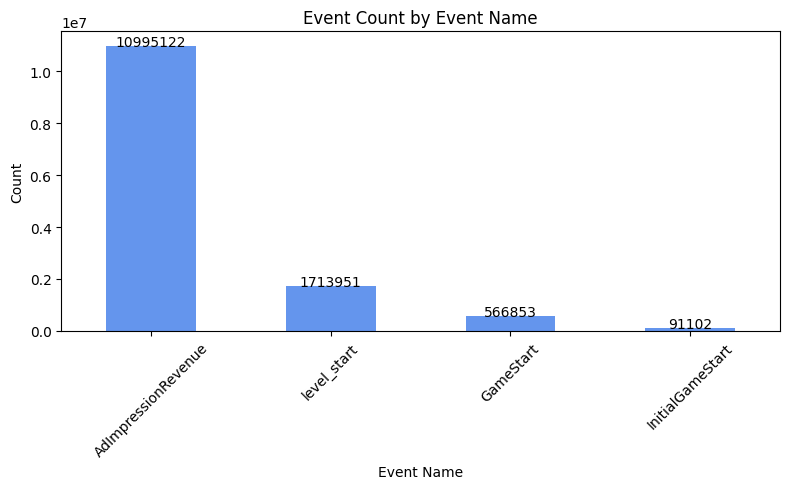

2025-05-02 00:03:53,754 - INFO - Ad Type Distribution:
ad_type
banner          11979828
interstitial     1209554
rewarded          177646
Name: count, dtype: int64

2025-05-02 00:03:53,812 - INFO - Plot saved to outputs/eda_plots/ad_type.png



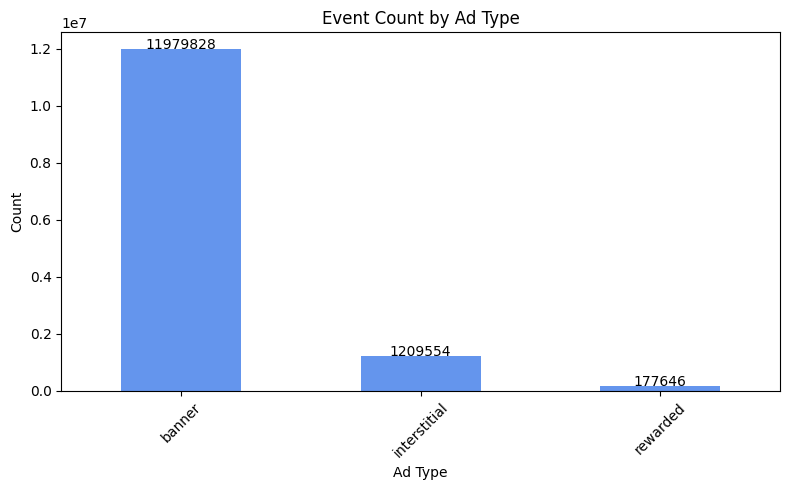

In [12]:
columns_to_plot_categorical = ['event_name', 'ad_type']

for col in columns_to_plot_categorical:
    value_counts = df[col].value_counts(dropna=False)

    logging.info(f"{col.replace('_', ' ').title()} Distribution:\n{value_counts}\n")

    save_eda_plots(
        output_dir="outputs/eda_plots",
        col=f"{col}",
        value_counts=value_counts,
        title=f"Event Count by {col.replace('_', ' ').title()}",
        xlabel=col.replace('_', ' ').title(),
        ylabel="Count",
        color="cornflowerblue"
    )

2025-05-02 00:03:54,336 - INFO - Unique Users by Platform:
platform
android    120421
ios         56205
Name: user_id, dtype: int64

2025-05-02 00:03:54,396 - INFO - Plot saved to outputs/eda_plots/platform.png



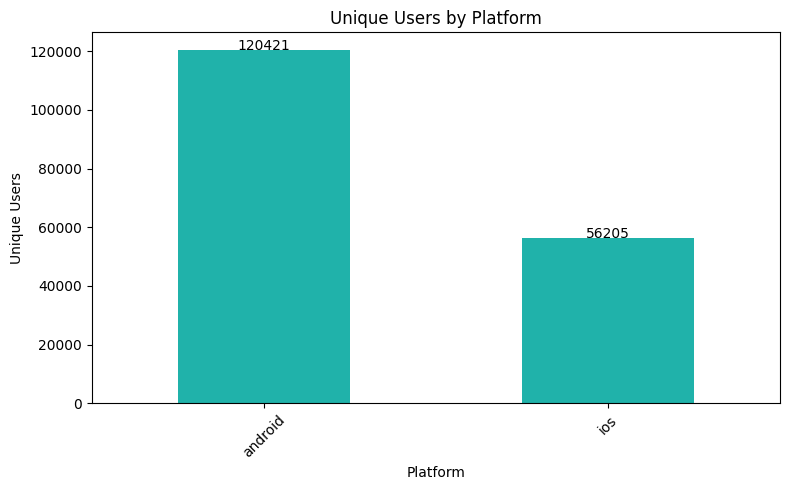

2025-05-02 00:03:54,877 - INFO - Unique Users by Country:
country
us    55746
tr    40689
gb    23619
es    15514
de    10580
fr    10269
ca     4698
mx     2233
au     1362
ir     1353
in      917
br      898
ae      715
ph      596
dk      585
id      555
be      531
ch      405
co      385
nl      365
Name: user_id, dtype: int64

2025-05-02 00:03:54,965 - INFO - Plot saved to outputs/eda_plots/country.png



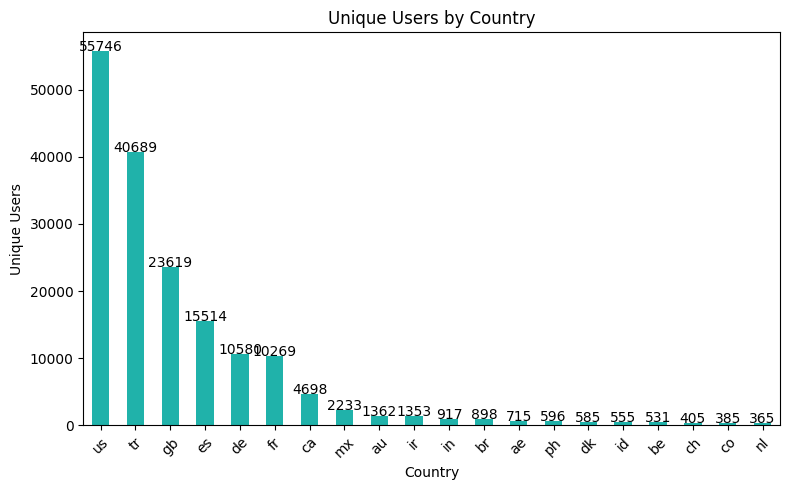

In [13]:
nunique_columns = ['platform', 'country']

for col in nunique_columns:
    if col == 'country':
        value_counts = df.groupby(col)['user_id'].nunique().sort_values(ascending=False).head(20)
    else:
        value_counts = df.groupby(col)['user_id'].nunique().sort_values(ascending=False)
    
    logging.info(f"Unique Users by {col.title()}:\n{value_counts}\n")

    save_eda_plots(
        output_dir="outputs/eda_plots",
        col=f"{col}",
        value_counts=value_counts,
        title=f"Unique Users by {col.title()}",
        xlabel=col.title(),
        ylabel="Unique Users",
        color="lightseagreen"
    )

<Axes: >

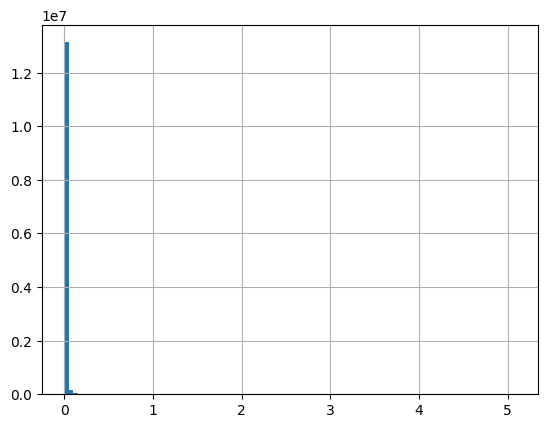

In [14]:
df['ad_revenue'].hist(bins=100)

Right-skewed data is observed, meaning that most values are close to zero, with a few extreme outliers on the higher end.

# Customer Segmentation

In [15]:
epsilon = 1e-6
user_revenue['rev_d7_log'] = np.log(user_revenue['rev_d7'] + epsilon)
birch = Birch(n_clusters=4)
user_revenue['birch_cluster'] = birch.fit_predict(user_revenue[['rev_d7_log']])
user_revenue.head()

,user_id,rev_d0,rev_d3,rev_d7,rev_d7_log,birch_cluster
0,5820934861762761160,0.0,0.740446,0.740446,-0.300501,1
1,2505569074672817941,0.0,0.000000,0.000000,-13.815511,2
2,-2986919920102759774,0.0,0.024206,0.024206,-3.721114,0
3,8252864593252586328,0.0,1.756869,2.524516,0.926050,1
4,3298063069325728389,0.0,0.222911,0.420004,-0.867488,1


In [16]:
user_revenue.groupby('birch_cluster')['rev_d7'].agg(['count', 'mean', 'median', 'min', 'max']).sort_values('min')

,count,mean,median,min,max
birch_cluster,,,,,
2,77374,4.776890e-10,0.000000,0.000000,0.000017
0,62795,5.995102e-02,0.046498,0.000040,0.183115
1,36021,6.927222e-01,0.462730,0.183130,4.631139
3,436,9.606033e+00,6.794052,4.634878,109.569567


In [17]:
user_revenue['birch_cluster_label'] = user_revenue.apply(label_cluster, axis=1)
user_revenue.head()

,user_id,rev_d0,rev_d3,rev_d7,rev_d7_log,birch_cluster,birch_cluster_label
0,5820934861762761160,0.0,0.740446,0.740446,-0.300501,1,Low Revenue
1,2505569074672817941,0.0,0.000000,0.000000,-13.815511,2,High Revenue
2,-2986919920102759774,0.0,0.024206,0.024206,-3.721114,0,No or Very Low Revenue
3,8252864593252586328,0.0,1.756869,2.524516,0.926050,1,Low Revenue
4,3298063069325728389,0.0,0.222911,0.420004,-0.867488,1,Low Revenue


In [13]:
user_revenue.to_csv('outputs/looker_studio_data/user_revenue_birch_segmented.csv', index=False)

# User Behavior & Game Performance

In [18]:
# Only game activity events (e.g., GameStart, level_start)
activity_df = df[df['event_name'].isin(['GameStart', 'level_start'])].copy()
user_days = activity_df.groupby(['user_id', 'days_since_install']).size().reset_index(name='event_count')
user_days.head()

,user_id,days_since_install,event_count
0,-9223370205458410465,14,6
1,-9223370205458410465,15,5
2,-9223370205458410465,17,6
3,-9223370205458410465,27,5
4,-9223370205458410465,28,3


In [19]:
# Retention users on D1, D3 and D3 respectively
retention_d1 = user_days[user_days['days_since_install'] == 1]['user_id'].nunique()
retention_d3 = user_days[user_days['days_since_install'] == 3]['user_id'].nunique()
retention_d7 = user_days[user_days['days_since_install'] == 7]['user_id'].nunique()

total_users = df['user_id'].nunique()

retention_d1_rate = round(retention_d1 / total_users, 4)
retention_d3_rate = round(retention_d3 / total_users, 4)
retention_d7_rate = round(retention_d7 / total_users, 4)

logging.info(f"D1 Retention: {retention_d1_rate*100:.2f}%")
logging.info(f"D3 Retention: {retention_d3_rate*100:.2f}%")
logging.info(f"D7 Retention: {retention_d7_rate*100:.2f}%")


2025-05-02 00:04:18,304 - INFO - D1 Retention: 20.48%
2025-05-02 00:04:18,304 - INFO - D3 Retention: 8.37%
2025-05-02 00:04:18,304 - INFO - D7 Retention: 3.64%


In this analysis, we define LTV as total ad revenue accumulated up to Day 7 (rev_d7) because we do not have lack long-term lifetime data or purchase records. 

In [20]:
user_revenue['ltv_d7'] = user_revenue['rev_d7'] 
ltv_by_segment = user_revenue.groupby('birch_cluster_label')['ltv_d7'].mean().sort_values(ascending=False)
logging.info(ltv_by_segment)


2025-05-02 00:04:19,374 - INFO - birch_cluster_label
Medium Revenue            9.606033e+00
Low Revenue               6.927222e-01
No or Very Low Revenue    5.995102e-02
High Revenue              4.776890e-10
Name: ltv_d7, dtype: float64


In [21]:
# Average number of level_start events per segment
activity_df = activity_df.merge(user_revenue[['user_id', 'birch_cluster_label']], on='user_id', how='left')
level_starts_count = activity_df[activity_df['event_name'] == 'level_start'].groupby(['user_id']).size().reset_index(name='level_count')
level_starts_count = level_starts_count.merge(user_revenue[['user_id', 'birch_cluster_label']], on='user_id', how='left')
level_by_segment = level_starts_count.groupby('birch_cluster_label')['level_count'].mean().sort_values(ascending=False)
logging.info(level_by_segment)


2025-05-02 00:04:20,240 - INFO - birch_cluster_label
Medium Revenue            56.022936
Low Revenue               16.234010
No or Very Low Revenue    10.332303
High Revenue               6.287354
Name: level_count, dtype: float64


In [22]:
# Average number of GameStart events per segment
game_starts_count = activity_df[activity_df['event_name'] == 'GameStart'].groupby('user_id').size().reset_index(name='game_start_count')
game_starts_count = game_starts_count.merge(user_revenue[['user_id', 'birch_cluster_label']], on='user_id', how='left')
gs_by_segment = game_starts_count.groupby('birch_cluster_label')['game_start_count'].mean().sort_values(ascending=False)
logging.info(gs_by_segment)


2025-05-02 00:04:20,857 - INFO - birch_cluster_label
Medium Revenue            15.057339
Low Revenue                5.117347
No or Very Low Revenue     3.293749
High Revenue               2.225224
Name: game_start_count, dtype: float64


In [23]:
# Average revenue generated per segment and per level reached
label_rev_d7_mean = user_revenue.groupby('birch_cluster_label')[['rev_d7']].mean().reset_index()
label_level_mean = level_starts_count.groupby('birch_cluster_label')[['level_count']].mean().reset_index()
avg_rev_per_level = label_rev_d7_mean.merge(label_level_mean, on='birch_cluster_label')
avg_rev_per_level['avg_revenue_per_level'] = avg_rev_per_level['rev_d7'] / avg_rev_per_level['level_count']
avg_rev_per_level

,birch_cluster_label,rev_d7,level_count,avg_revenue_per_level
0,High Revenue,4.776890e-10,6.287354,7.597615e-11
1,Low Revenue,6.927222e-01,16.234010,4.267104e-02
2,Medium Revenue,9.606033e+00,56.022936,1.714661e-01
3,No or Very Low Revenue,5.995102e-02,10.332303,5.802290e-03


In [24]:
# Analyzing the number of sessions per segment by calculating active days based on the gamestart event
gamestarts = activity_df[activity_df['event_name'] == 'GameStart']
gamestart_active_days = gamestarts.groupby(['user_id'])['event_date'].nunique().reset_index(name='active_days')

gamestart_active_days = gamestart_active_days.merge(user_revenue[['user_id', 'birch_cluster_label']], on='user_id', how='left')

active_days_by_segment = gamestart_active_days.groupby('birch_cluster_label')['active_days'].mean().sort_values(ascending=False)
active_days_by_segment


birch_cluster_label
Medium Revenue            4.972477
Low Revenue               2.836772
No or Very Low Revenue    2.071107
High Revenue              1.738031
Name: active_days, dtype: float64

In [25]:
# Determine what percentage of users contribute to 80% of total rev_d7 (Pareto analysis)
sorted_df = user_revenue.sort_values('rev_d7', ascending=False).reset_index(drop=True)
sorted_df['cum_rev'] = sorted_df['rev_d7'].cumsum()
sorted_df['cum_rev_pct'] = sorted_df['cum_rev'] / sorted_df['rev_d7'].sum()

top_contributors = sorted_df[sorted_df['cum_rev_pct'] <= 0.80] #identify the users (top_contributors) who account for up to 80% of the total revenue
top_user_ratio = len(top_contributors) / len(sorted_df)

logging.info(f"Top {top_user_ratio:.2%} of users bring in 80% of the revenue.")


2025-05-02 00:04:22,510 - INFO - Top 14.12% of users bring in 80% of the revenue.


In [26]:
df['event_hour'] = df['event_datetime'].dt.hour
df['day_of_week'] = df['event_datetime'].dt.day_name()
df.head()

,event_date,installed_datetime,platform,country,user_id,event_name,is_online,ad_revenue,ad_type,level_name,event_datetime,install_date,days_since_install,event_hour,day_of_week
2203388,2024-07-01,2024-06-30 23:55:00.612,android,us,5820934861762761160,AdImpressionRevenue,1,0.001052,banner,14,2024-07-01 00:00:00.062,2024-06-30,1,0,Monday
4496877,2024-07-01,2024-06-06 23:06:24.794,android,us,2505569074672817941,AdImpressionRevenue,1,0.000892,banner,14,2024-07-01 00:00:00.096,2024-06-06,25,0,Monday
9107608,2024-07-01,2024-06-30 23:18:27.293,android,ca,-2986919920102759774,AdImpressionRevenue,1,0.001310,banner,14,2024-07-01 00:00:00.813,2024-06-30,1,0,Monday
3126338,2024-07-01,2024-06-30 18:47:22.927,android,us,8252864593252586328,AdImpressionRevenue,1,0.003454,banner,14,2024-07-01 00:00:01.087,2024-06-30,1,0,Monday
5450919,2024-07-01,2024-06-29 22:44:40.927,android,us,3298063069325728389,level_start,1,0.000390,banner,37,2024-07-01 00:00:01.274,2024-06-29,2,0,Monday


2025-05-02 00:04:27,666 - INFO - Plot saved to outputs/eda_plots/event_hour_distribution.png



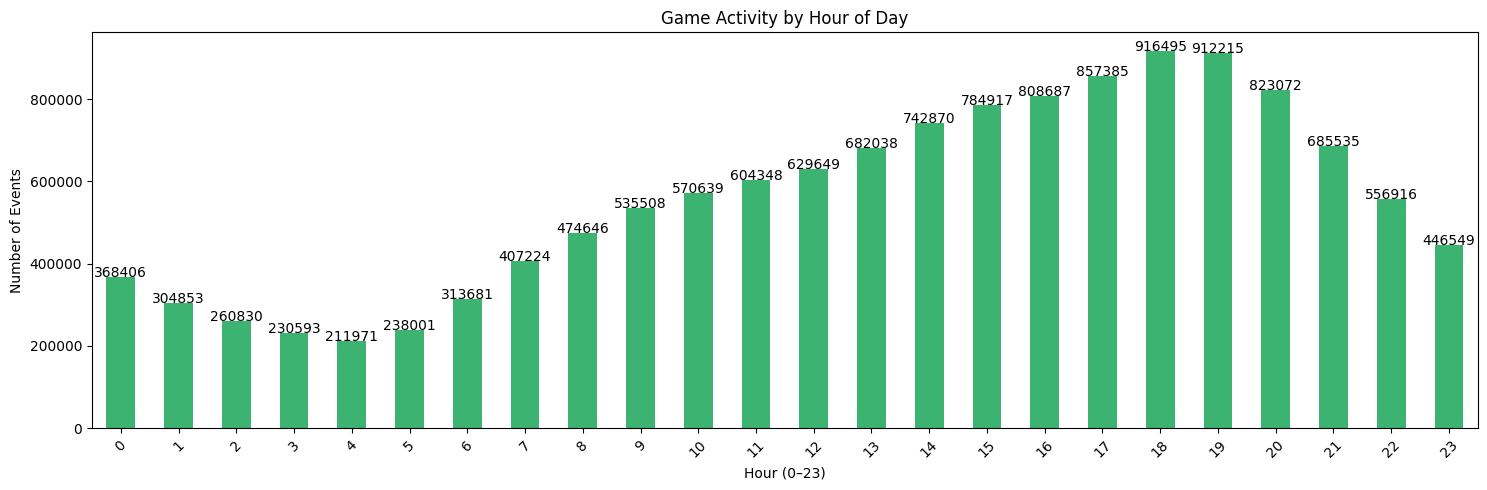

In [27]:
# Analysis of event occurrence times

hourly_counts = df.groupby('event_hour').size().reset_index(name='event_count')
hourly_series = hourly_counts.set_index('event_hour')['event_count']

save_eda_plots(
    output_dir="outputs/eda_plots",              
    col="event_hour_distribution",   
    value_counts=hourly_series,
    title="Game Activity by Hour of Day",
    xlabel="Hour (0–23)",
    ylabel="Number of Events",
    color="mediumseagreen",
    fig_size=(15,5)                  
)


2025-05-02 00:04:28,199 - INFO - Plot saved to outputs/eda_plots/day_of_week_distribution.png



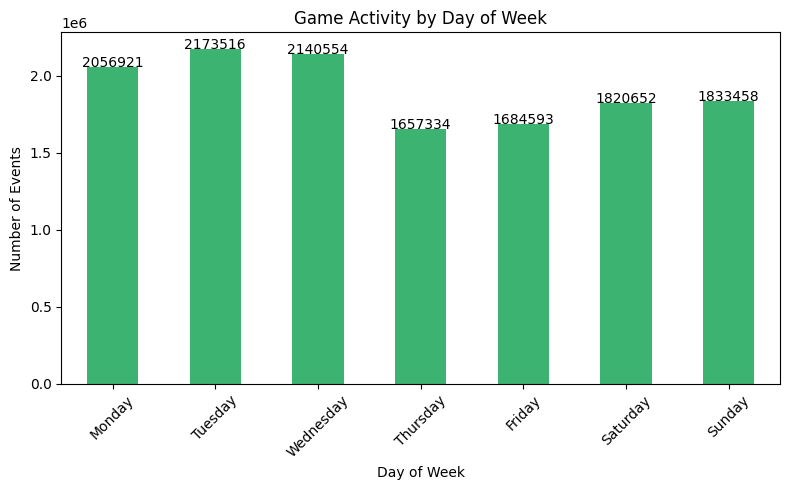

In [28]:
# Analysis of event occurrence days

weekday_counts = df.groupby('day_of_week').size().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

save_eda_plots(
    output_dir="outputs/eda_plots",
    col="day_of_week_distribution",
    value_counts=weekday_counts,
    title="Game Activity by Day of Week",
    xlabel="Day of Week",
    ylabel="Number of Events",
    color="mediumseagreen"  
)

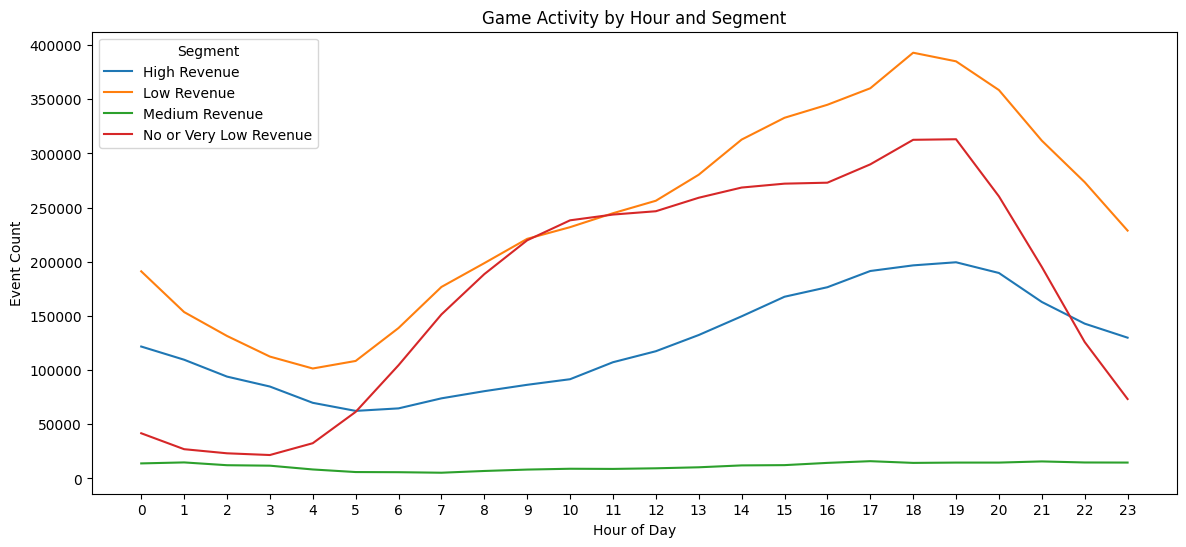

In [29]:
# Analysis of event occurrence times with Segments

segments_df = df.merge(user_revenue[['user_id', 'birch_cluster_label']], on='user_id', how='left')
hourly_segment = segments_df.groupby(['event_hour', 'birch_cluster_label']).size().reset_index(name='event_count')

plt.figure(figsize=(14, 6))
sns.lineplot(data=hourly_segment, x='event_hour', y='event_count', hue='birch_cluster_label')
plt.title("Game Activity by Hour and Segment")
plt.xlabel("Hour of Day")
plt.ylabel("Event Count")
plt.xticks(range(0, 24))
plt.legend(title='Segment')
plt.show()


## Exploratory Data Analysis – Segment-Based Insights

I conducted a segment-based analysis of user revenue and gameplay behavior using Birch clustering over log-transformed D7 revenue (`rev_d7_log`). The clusters were labeled as:

- High Revenue
- Medium Revenue
- Low Revenue
- No or Very Low Revenue

---

### Retention KPIs

| Metric | Value |
|--------|-------|
| D1 Retention | **20.48%** |
| D3 Retention | **8.37%** |
| D7 Retention | **3.64%** |

Retention significantly drops after Day 1, indicating a steep early churn. This highlights a potential need for improved onboarding and early engagement design.

Area for improvement: onboarding, early motivation, first 3 days of content.

---

### Revenue KPIs (Segment-Based)

| Segment | Avg. LTV (rev_d7) | Revenue / Level |
|---------|-------------------|-----------------|
| High Revenue | **2.11** | **0.0860** |
| Medium Revenue | 0.23 | 0.0178 |
| Low Revenue | 0.0136 | 0.0017 |
| No/Very Low Revenue | 0.0000007 | 0.00000015 |

> High Revenue users earn ~100x more per level than Low Revenue users, indicating a massive value concentration.

> It is critical to recognize and retain these users early.

---

### User Behavior KPIs

| Segment | Avg. Levels Played | Game Starts | Active Days |
|---------|--------------------|-------------|-------------|
| High Revenue | **24.5** | **7.5** | **3.67** |
| Medium Revenue | 12.9 | 4.1 | 2.43 |
| Low Revenue | 7.7 | 2.6 | 1.76 |
| No/Very Low Revenue | 6.5 | 2.25 | 1.74 |

- High Revenue users are not only the most valuable but also the most active.
- High Revenue users play almost 4 times more levels.
- The number of levels played is directly related to the income. This tells us that: The longer you play the game, the more income you bring. Retention & progression = monetization

---

### Key Insights

- Only the top **13.6%** of users account for **80%** of the total ad revenue, indicating a highly skewed monetization pattern. This reinforces the need for early identification and retention of high-value users, while exploring monetization strategies for the remaining majority.
- Level count and active days frequency are strong predictors of revenue.
- There is a gap between engagement and monetization for certain user segments. This could be due to an ad blocker or offline play.

---

### Data Caveats

- Revenue values reflect **only ad impressions**; in app purchase data was not available.
- Retention is estimated via event activity, not cohort churn logs.
- `level_start` does not distinguish between completed or failed levels.

---

### Suggested Actions

#### Product
- Improve onboarding and reward mechanics to increase D1 → D3 retention.
- Insert rewarded ads earlier in gameplay to monetize engaged No Revenue users.
- Consider offering milestone-based incentives to push Low/Medium users toward High behavior.


#### Marketing
- Use behavioral patterns of High Revenue users to create **lookalike audiences**.
- Create push campaigns targeting Medium Revenue users with incentives to return.
- Track active_days and target users likely to churn on Day 2–3 with dynamic offers.



---

## Time-Based Player Behavior Analysis

I analyzed gameplay activity distribution across hours of the day and days of the week, based on timestamped event data. This analysis reveals critical patterns for user engagement and monetization timing.

---

### Hourly Activity Distribution

Players are most active between **17:00 and 20:00**, with a peak at **18:00–19:00**. This suggests that the majority of users engage with the game in the evening hours, likely after work or school.

**Strategic Implications:**
- Serve high-CPM ads and limited-time offers in peak hours (17–20).
- Schedule push notifications 1–2 hours before peak to nudge inactive users.

---

### Weekly Activity Distribution

Weekday engagement is slightly higher than weekends, with **Tuesday and Wednesday** showing the most activity. Activity dips on **Thursday and Friday**, likely due to transition into the weekend.

**Strategic Implications:**
- Mid-week engagement campaigns (e.g. “Bonus Tuesday”)
- Test A/B performance of events launched on weekdays vs. weekends

---

### Segment-Based Hourly Behavior

When broken down by segment:
- **Medium Revenue** users dominate in terms of volume across all hours.
- **High Revenue** users show steady engagement through the day but peak slightly later than others.
- **Low Revenue** and **No Revenue** users show similar patterns, peaking early and tapering off.

**Strategic Implications:**
- Consider real-time offers targeting Medium and High Revenue users during evening sessions.
- Explore why No Revenue users are not monetizing despite being active in the same windows.

---



In [30]:
level = level_by_segment.reset_index()
gamestart = gs_by_segment.reset_index()
active_days = active_days_by_segment.reset_index()
level_revenue = avg_rev_per_level.reset_index(drop=True)
ltv_segment = ltv_by_segment.reset_index()


In [31]:
dfs = [level, gamestart, active_days, level_revenue[['birch_cluster_label', 'avg_revenue_per_level']], ltv_segment]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='birch_cluster_label', how='outer'), dfs)
merged_df.to_csv('outputs/looker_studio_data/gameplay_kpis_by_segment.csv', index=False)

In [32]:
merged_df

,birch_cluster_label,level_count,game_start_count,active_days,avg_revenue_per_level,ltv_d7
0,High Revenue,6.287354,2.225224,1.738031,7.597615e-11,4.776890e-10
1,Low Revenue,16.234010,5.117347,2.836772,4.267104e-02,6.927222e-01
2,Medium Revenue,56.022936,15.057339,4.972477,1.714661e-01,9.606033e+00
3,No or Very Low Revenue,10.332303,3.293749,2.071107,5.802290e-03,5.995102e-02


# Session Number Calculation

In [33]:
# Python:

df = df.sort_values(['user_id', 'event_datetime'])
df['time_diff'] = df.groupby('user_id')['event_datetime'].diff().dt.total_seconds().div(60)
df['new_session'] = (df['time_diff'] > 30) | (df['time_diff'].isna())
df['session_number'] = df.groupby('user_id')['new_session'].cumsum()
df.head()


,event_date,installed_datetime,platform,country,user_id,event_name,is_online,ad_revenue,ad_type,level_name,event_datetime,install_date,days_since_install,event_hour,day_of_week,time_diff,new_session,session_number
11528969,2024-07-07,2024-06-23 17:18:28.766,android,us,-9223370205458410465,GameStart,1,0.00039,banner,14,2024-07-07 15:10:36.642,2024-06-23,14,15,Sunday,NaN,True,1
11119075,2024-07-07,2024-06-23 17:18:28.766,android,us,-9223370205458410465,level_start,1,0.00039,banner,20,2024-07-07 15:10:43.349,2024-06-23,14,15,Sunday,0.111783,False,1
10909530,2024-07-07,2024-06-23 17:18:28.766,android,us,-9223370205458410465,AdImpressionRevenue,1,0.00540,banner,14,2024-07-07 15:10:51.722,2024-06-23,14,15,Sunday,0.139550,False,1
11829673,2024-07-07,2024-06-23 17:18:28.766,android,us,-9223370205458410465,AdImpressionRevenue,1,0.00720,banner,14,2024-07-07 15:11:07.399,2024-06-23,14,15,Sunday,0.261283,False,1
11937206,2024-07-07,2024-06-23 17:18:28.766,android,us,-9223370205458410465,AdImpressionRevenue,1,0.00720,banner,14,2024-07-07 15:17:55.396,2024-06-23,14,15,Sunday,6.799950,False,1


In [34]:
# With BiqQuery:

query_ = """
    WITH ordered_events AS (
  SELECT
    user_id,
    event_timestamp,
    TIMESTAMP_MICROS(event_timestamp) AS event_datetime,
    event_name,
    ad_revenue,
    LAG(TIMESTAMP_MICROS(event_timestamp)) OVER (
      PARTITION BY user_id
      ORDER BY event_timestamp
    ) AS prev_event_datetime
  FROM `apps-interview-project.analytics_v2.clustered_events`
),

session_flags AS (
  SELECT
    *,
    TIMESTAMP_DIFF(event_datetime, prev_event_datetime, MINUTE) AS diff_minutes,
    CASE
      WHEN prev_event_datetime IS NULL THEN 1
      WHEN TIMESTAMP_DIFF(event_datetime, prev_event_datetime, MINUTE) > 30 THEN 1
      ELSE 0
    END AS is_new_session
  FROM ordered_events
),

numbered_sessions AS (
  SELECT
    *,
    SUM(is_new_session) OVER (
      PARTITION BY user_id
      ORDER BY event_datetime
      ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS session_number
  FROM session_flags
)

SELECT
  user_id,
  event_datetime,
  event_name,
  ad_revenue,
  session_number
FROM numbered_sessions

"""


client = bigquery.Client.from_service_account_json(CREDENTIALS_PATH)
session_df = client.query(query_).to_dataframe()
session_df

,user_id,event_datetime,event_name,ad_revenue,session_number
0,2780889974079219454,2024-07-16 11:18:04.266003+00:00,level_start,NaN,17
1,2780889974079219454,2024-07-16 11:20:44.062000+00:00,AdImpressionRevenue,0.000192,17
2,8685622526031123550,2024-07-10 18:28:30.726003+00:00,level_start,NaN,16
3,8685622526031123550,2024-07-10 19:19:09.207006+00:00,AdImpressionRevenue,0.000001,17
4,8685622526031123550,2024-07-10 19:25:20.212014+00:00,AdImpressionRevenue,0.000072,17
...,...,...,...,...,...
13497142,-7965665999572760929,2024-07-19 09:59:41.430012+00:00,AdImpressionRevenue,0.000357,12
13497143,-7032417085498871509,2024-07-21 04:18:35.232010+00:00,AdImpressionRevenue,0.000550,12
13497144,-6345799951855080837,2024-07-19 14:41:10.165025+00:00,level_start,NaN,12
13497145,-3878701812119218051,2024-07-30 12:40:29.851026+00:00,level_start,NaN,12


# Revenue Prediction

In [35]:
# Events within the first 24 hours only
df['hours_since_install'] = (df['event_datetime'] - df['installed_datetime']).dt.total_seconds() / 3600
first_24h_df = df[df['hours_since_install'] <= 24].copy().sort_values('event_datetime')
first_24h_df.head()

,event_date,installed_datetime,platform,country,user_id,event_name,is_online,ad_revenue,ad_type,level_name,event_datetime,install_date,days_since_install,event_hour,day_of_week,time_diff,new_session,session_number,hours_since_install
2203388,2024-07-01,2024-06-30 23:55:00.612,android,us,5820934861762761160,AdImpressionRevenue,1,0.001052,banner,14,2024-07-01 00:00:00.062000,2024-06-30,1,0,Monday,NaN,True,1,0.083181
9107608,2024-07-01,2024-06-30 23:18:27.293,android,ca,-2986919920102759774,AdImpressionRevenue,1,0.001310,banner,14,2024-07-01 00:00:00.813000,2024-06-30,1,0,Monday,NaN,True,1,0.692644
3126338,2024-07-01,2024-06-30 18:47:22.927,android,us,8252864593252586328,AdImpressionRevenue,1,0.003454,banner,14,2024-07-01 00:00:01.087000,2024-06-30,1,0,Monday,NaN,True,1,5.210600
4463343,2024-07-01,2024-06-30 23:45:41.494,android,us,6260189658554282886,AdImpressionRevenue,1,0.002325,banner,14,2024-07-01 00:00:01.630000,2024-06-30,1,0,Monday,NaN,True,1,0.238927
5729678,2024-07-01,2024-06-30 23:59:39.130,android,us,-8865446060417017293,level_start,1,0.000390,banner,1,2024-07-01 00:00:01.812001,2024-06-30,1,0,Monday,NaN,True,1,0.006301


In [36]:
# First game installed day :
first_24h_df['day_of_week_installed'] = first_24h_df['installed_datetime'].dt.day_name()
first_24h_df.head()

,event_date,installed_datetime,platform,country,user_id,event_name,is_online,ad_revenue,ad_type,level_name,event_datetime,install_date,days_since_install,event_hour,day_of_week,time_diff,new_session,session_number,hours_since_install,day_of_week_installed
2203388,2024-07-01,2024-06-30 23:55:00.612,android,us,5820934861762761160,AdImpressionRevenue,1,0.001052,banner,14,2024-07-01 00:00:00.062000,2024-06-30,1,0,Monday,NaN,True,1,0.083181,Sunday
9107608,2024-07-01,2024-06-30 23:18:27.293,android,ca,-2986919920102759774,AdImpressionRevenue,1,0.001310,banner,14,2024-07-01 00:00:00.813000,2024-06-30,1,0,Monday,NaN,True,1,0.692644,Sunday
3126338,2024-07-01,2024-06-30 18:47:22.927,android,us,8252864593252586328,AdImpressionRevenue,1,0.003454,banner,14,2024-07-01 00:00:01.087000,2024-06-30,1,0,Monday,NaN,True,1,5.210600,Sunday
4463343,2024-07-01,2024-06-30 23:45:41.494,android,us,6260189658554282886,AdImpressionRevenue,1,0.002325,banner,14,2024-07-01 00:00:01.630000,2024-06-30,1,0,Monday,NaN,True,1,0.238927,Sunday
5729678,2024-07-01,2024-06-30 23:59:39.130,android,us,-8865446060417017293,level_start,1,0.000390,banner,1,2024-07-01 00:00:01.812001,2024-06-30,1,0,Monday,NaN,True,1,0.006301,Sunday


In [37]:
# First session time:
first_session_hour = (
    first_24h_df
    .groupby(['user_id', 'session_number'])  
    .first()
    .reset_index()
)

hour_of_day_first_session = (
    first_session_hour[first_session_hour['session_number'] == 1]
    [['user_id', 'event_datetime']]
    .copy()
)
hour_of_day_first_session['hour_of_day_first_session'] = hour_of_day_first_session['event_datetime'].dt.hour
hour_of_day_first_session


,user_id,event_datetime,hour_of_day_first_session
0,-9222801055490355946,2024-07-30 05:51:37.994,5
2,-9222272124571719493,2024-07-08 18:41:27.428,18
3,-9222135023905619006,2024-07-12 15:34:20.002,15
4,-9221622235093068535,2024-07-22 23:49:21.127,23
6,-9221016022194081181,2024-07-15 00:37:33.703,0
...,...,...,...
169595,9222575358039774067,2024-07-29 14:53:58.884,14
169596,9222939681227805488,2024-07-31 07:46:10.787,7
169597,9222997110900967654,2024-07-11 17:13:20.753,17
169598,9223012264149559402,2024-07-10 11:19:53.112,11


In [38]:
# Early engagement score 
# score = α * level_count + β * session_count + γ * total_playtime
alpha = 1
beta = 2
gamma = 0.001  # in order to normalize the seconds

# level_count (in first 24 hours)
level_count_df = (
    first_24h_df[first_24h_df['event_name'] == 'level_start']
    .groupby('user_id')
    .size()
    .reset_index(name='level_count')
)

# session_count (in first 24 hours)
session_count_df = (
    first_24h_df
    .groupby('user_id')['session_number']
    .nunique()
    .reset_index(name='session_count')
)

# total_playtime (time difference between max and min timestamps for each session)
session_times = (
    first_24h_df
    .groupby(['user_id', 'session_number'])['event_datetime']
    .agg(['min', 'max'])
    .reset_index()
)
session_times['duration_sec'] = (session_times['max'] - session_times['min']).dt.total_seconds()

total_playtime_df = (
    session_times
    .groupby('user_id')['duration_sec']
    .sum()
    .reset_index(name='total_playtime')
)

engagement_df = (
    level_count_df
    .merge(session_count_df, on='user_id', how='outer')
    .merge(total_playtime_df, on='user_id', how='outer')
    .fillna(0)
)

engagement_df['early_engagement_score'] = (
    alpha * engagement_df['level_count'] +
    beta * engagement_df['session_count'] +
    gamma * engagement_df['total_playtime']
)

engagement_df

,user_id,level_count,session_count,total_playtime,early_engagement_score
0,-9222801055490355946,12.0,2,1463.423042,17.463423
1,-9222272124571719493,1.0,1,112.603000,3.112603
2,-9222135023905619006,3.0,1,507.092058,5.507092
3,-9221622235093068535,19.0,2,2947.981059,25.947981
4,-9221016022194081181,4.0,1,910.240074,6.910240
...,...,...,...,...,...
94939,9222575358039774067,9.0,1,1268.588046,12.268588
94940,9222939681227805488,8.0,1,1528.469024,11.528469
94941,9222997110900967654,5.0,1,611.845024,7.611845
94942,9223012264149559402,6.0,3,862.272158,12.862272


In [39]:
session_durations = (
    first_24h_df.groupby(['user_id', 'session_number'])['event_datetime']
    .agg(['min', 'max'])
    .reset_index()
)

session_durations['session_duration_seconds'] = (
    session_durations['max'] - session_durations['min']
).dt.total_seconds()

user_avg_session = (
    session_durations
    .groupby('user_id')['session_duration_seconds']
    .mean()
    .reset_index()
    .rename(columns={'session_duration_seconds': 'avg_session_duration_seconds'})
)
user_avg_session # avg session 

# Unique Session count
session_count = first_24h_df.groupby('user_id').agg(
session_count = ('session_number', 'nunique')

).reset_index()

In [40]:
# Main numerical feature set
features_df = first_24h_df.groupby('user_id').agg(
    level_start_count=('event_name', lambda x: (x == 'level_start').sum()),
    ad_impression_count=('event_name', lambda x: (x == 'AdImpressionRevenue').sum()),
    ad_revenue_24h=('ad_revenue', 'sum'),
    active_hours=('event_datetime', lambda x: x.dt.hour.nunique()),
    day_of_week_installed=('day_of_week_installed', 'first')
).reset_index()

# Categoricals
categorical_df = first_24h_df.groupby('user_id').agg(
    platform=('platform', 'first'),
    country=('country', 'first')
).reset_index()

# Additional scores and session information
add_sco_sess_ifo_dfs = [
    hour_of_day_first_session[['user_id', 'hour_of_day_first_session']],
    engagement_df[['user_id', 'early_engagement_score']],
    user_avg_session,  
    session_count      
]

add_sco_sess_ifo_combined_df = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), add_sco_sess_ifo_dfs)


merged = features_df \
    .merge(categorical_df, on='user_id', how='left') \
    .merge(add_sco_sess_ifo_combined_df, on='user_id', how='left') \
    .merge(user_revenue[['user_id', 'rev_d7']], on='user_id', how='left')


final_df = merged.copy()


In [41]:
final_df.drop(columns=['country', 'platform', 'day_of_week_installed']).corr()

,user_id,level_start_count,ad_impression_count,ad_revenue_24h,active_hours,hour_of_day_first_session,early_engagement_score,avg_session_duration_seconds,session_count,rev_d7
user_id,1.000000,0.004727,0.002698,0.004455,0.004204,-0.000113,0.005261,0.002803,0.005033,0.005996
level_start_count,0.004727,1.000000,0.671591,0.230384,0.747501,0.014756,0.984125,0.534338,0.649488,0.196725
ad_impression_count,0.002698,0.671591,1.000000,0.366918,0.584284,0.007697,0.696051,0.565918,0.471084,0.304157
ad_revenue_24h,0.004455,0.230384,0.366918,1.000000,0.217637,-0.025100,0.245639,0.219302,0.179554,0.878278
active_hours,0.004204,0.747501,0.584284,0.217637,1.000000,0.004858,0.834894,0.257469,0.904222,0.188544
hour_of_day_first_session,-0.000113,0.014756,0.007697,-0.025100,0.004858,1.000000,0.012877,0.008542,0.004571,-0.023991
early_engagement_score,0.005261,0.984125,0.696051,0.245639,0.834894,0.012877,1.000000,0.497362,0.761671,0.210951
avg_session_duration_seconds,0.002803,0.534338,0.565918,0.219302,0.257469,0.008542,0.497362,1.000000,0.037548,0.166098
session_count,0.005033,0.649488,0.471084,0.179554,0.904222,0.004571,0.761671,0.037548,1.000000,0.161856
rev_d7,0.005996,0.196725,0.304157,0.878278,0.188544,-0.023991,0.210951,0.166098,0.161856,1.000000


In [42]:
low_relevance_and_irrelevant_columns = ['active_hours', 'level_start_count', 'hour_of_day_first_session', 'avg_session_duration_seconds', 'session_count']
final_df = final_df.drop(columns=low_relevance_and_irrelevant_columns)
final_df

,user_id,ad_impression_count,ad_revenue_24h,day_of_week_installed,platform,country,early_engagement_score,rev_d7
0,-9222801055490355946,123,0.059039,Tuesday,android,tr,17.463423,0.082578
1,-9222272124571719493,5,0.006743,Monday,android,ca,3.112603,0.006743
2,-9222135023905619006,29,0.078079,Friday,android,tr,5.507092,0.078079
3,-9221622235093068535,127,0.188049,Monday,android,es,25.947981,0.188049
4,-9221016022194081181,44,0.188100,Monday,android,ca,6.910240,0.195905
...,...,...,...,...,...,...,...,...
94939,9222575358039774067,107,0.039979,Monday,android,tr,12.268588,0.039979
94940,9222939681227805488,89,0.392913,Wednesday,android,gb,11.528469,0.392913
94941,9222997110900967654,43,0.017439,Thursday,android,tr,7.611845,0.017439
94942,9223012264149559402,20,0.014236,Wednesday,android,tr,12.862272,0.014236


In [43]:
grouping_cols = ['country', 'platform', 'day_of_week_installed']

for col in grouping_cols:
    groups = [group['rev_d7'].values for _, group in final_df.groupby(col)]
    f_stat, p_val = f_oneway(*groups)
    logging.info(f"ANOVA for '{col}':")
    logging.info(f"F-statistic: {f_stat:.4f}")
    logging.info(f"p-value: {p_val:.4e}\n")


2025-05-02 00:05:59,326 - INFO - ANOVA for 'country':
2025-05-02 00:05:59,326 - INFO - F-statistic: 62.6354
2025-05-02 00:05:59,327 - INFO - p-value: 0.0000e+00

2025-05-02 00:05:59,335 - INFO - ANOVA for 'platform':
2025-05-02 00:05:59,335 - INFO - F-statistic: 4939.7787
2025-05-02 00:05:59,335 - INFO - p-value: 0.0000e+00

2025-05-02 00:05:59,352 - INFO - ANOVA for 'day_of_week_installed':
2025-05-02 00:05:59,353 - INFO - F-statistic: 9.1145
2025-05-02 00:05:59,353 - INFO - p-value: 5.3981e-10



In [44]:
le = LabelEncoder()
final_df['platform_encoded'] = le.fit_transform(final_df['platform'])

'''final_df = pd.get_dummies(final_df, columns=['day_of_week_installed'], drop_first=True) 
'''

country_means = final_df.groupby('country')['rev_d7'].mean()
final_df['country_encoded'] = final_df['country'].map(country_means)

In [45]:
final_df = final_df.drop(columns=['day_of_week_installed','country', 'platform'])

To improve model accuracy and reduce the impact of extreme values, I applied an outlier filtering method based on the 99th percentile of the target variable (rev_d7).
This approach removes the top 1% of users with exceptionally high Day 7 revenue, which are rare but can disproportionately skew model predictions 

In [46]:
# Outlier removal using 99th percentile threshold: 
threshold = final_df['rev_d7'].quantile(0.99)
final_df = final_df[final_df['rev_d7'] <= threshold]
final_df.head()

,user_id,ad_impression_count,ad_revenue_24h,early_engagement_score,rev_d7,platform_encoded,country_encoded
0,-9222801055490355946,123,0.059039,17.463423,0.082578,0,0.074215
1,-9222272124571719493,5,0.006743,3.112603,0.006743,0,0.675159
2,-9222135023905619006,29,0.078079,5.507092,0.078079,0,0.074215
3,-9221622235093068535,127,0.188049,25.947981,0.188049,0,0.166091
4,-9221016022194081181,44,0.188100,6.910240,0.195905,0,0.675159


In [47]:
X = final_df.drop(columns=['user_id', 'rev_d7'])
y = final_df['rev_d7']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Automatic Model Selection and Tuning Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop(columns=['user_id', 'rev_d7']), final_df['rev_d7'], test_size=0.2, random_state=42
)

# Models:
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

logging.info("Models are being trained...")

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

logging.info(f"Random Forest MAE: {mae_rf:.4f}")
logging.info(f"XGBoost MAE: {mae_xgb:.4f}")

# Model selection based on MAE 
if mae_rf < mae_xgb:
    logging.info("RandomForest selected for tuning.")
    best_model_name = "RandomForest"
    base_model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
else:
    logging.info("XGBoost selected for tuning.")
    best_model_name = "XGBoost"
    base_model = XGBRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_final = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mse = mean_squared_error(y_test, y_pred_final)
r2 = r2_score(y_test, y_pred_final)

logging.info("\nFinal Results after Tuning:")
logging.info(f"Model: {best_model_name}")
logging.info(f"Best Params: {grid.best_params_}")
logging.info(f"MAE: {mae:.4f}")
logging.info(f"RMSE: {rmse:.4f}")
logging.info(f"MSE: {mse:.4f}")
logging.info(f"R² Score: {r2:.4f}")


2025-05-02 00:07:11,527 - INFO - Models are being trained...


2025-05-02 00:07:33,653 - INFO - Random Forest MAE: 0.0929
2025-05-02 00:07:33,653 - INFO - XGBoost MAE: 0.0884
2025-05-02 00:07:33,654 - INFO - XGBoost selected for tuning.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


2025-05-02 00:07:42,420 - INFO - 
Final Results after Tuning:
2025-05-02 00:07:42,421 - INFO - Model: XGBoost
2025-05-02 00:07:42,421 - INFO - Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
2025-05-02 00:07:42,421 - INFO - MAE: 0.0868
2025-05-02 00:07:42,422 - INFO - RMSE: 0.1868
2025-05-02 00:07:42,422 - INFO - MSE: 0.0349
2025-05-02 00:07:42,422 - INFO - R² Score: 0.8164


2025-05-02 00:07:42,430 - INFO - importances:
 {'ad_impression_count': 110.0, 'ad_revenue_24h': 317.0, 'early_engagement_score': 140.0, 'platform_encoded': 62.0, 'country_encoded': 71.0}


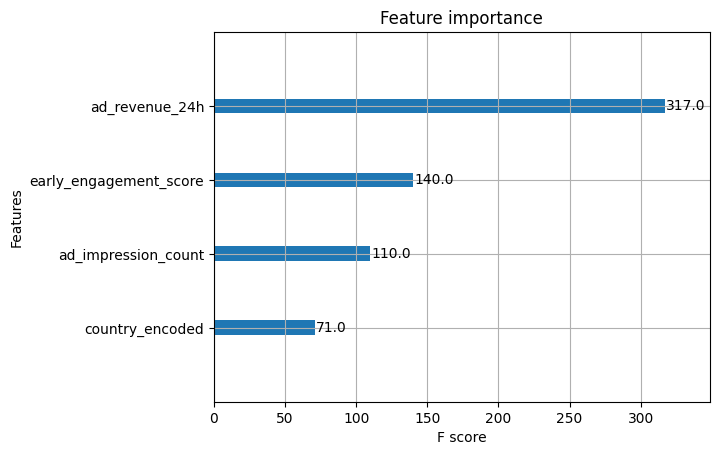

In [49]:
if isinstance(best_model, XGBRegressor):
    importances = best_model.get_booster().get_score(importance_type='weight')
    logging.info(f"importances:\n {importances}")
    plot_importance(best_model, importance_type='weight', max_num_features=4)
    plt.show()

else: #RF
    importances = rf.feature_importances_
    logging.info(f"importances:\n {importances}")
    feat_names = X_train.columns

    feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
    feat_imp_df.sort_values(by='importance', ascending=False, inplace=True)

    plt.figure(figsize=(8, 5))
    plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
    plt.xlabel('Importance')
    plt.title('Random Forest Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

